# Example workflow for capturing and then postprocessing images

## Import packages

In [1]:
import numpy as np
from math import log2,ceil
import cv2 as cv
import zwoasi as asi
import datetime
import matplotlib.pyplot as plt

## Initialize Camera

### Camera Constants

In [2]:
bayerpatt = ['RGGB', 'BGGR', 'GRBG', 'GBRG'] # Sequence of Bayer pattern in rows then columns
imgformat = ['RAW8', 'RGB24', 'RAW16', 'Y8'] # Supported image formats

In [3]:
asi.init('/usr/lib/libASICamera2.so')

In [4]:
num_cameras = asi.get_num_cameras()

In [5]:
if num_cameras == 1:
    camera_id = 0
    print('Found one camera: %s' % asi.list_cameras()[camera_id])
camera = asi.Camera(camera_id)

Found one camera: ZWO ASI178MC


### Show Camera controls and properties

In [6]:
camera_info = camera.get_camera_property()
print('Camera Properties:')
for k, v in camera_info.items():
    if isinstance(v, list):
        print('{:<28}:'.format(k), '[%s]' % ', '.join(map(str, v)))
        if k == 'SupportedVideoFormat':
            print('{:<28}:'.format(k + ' decoded'), '[%s]' % ', '.\
                  join(map(lambda idx: str(imgformat[idx]), v)))
    else:
        print('{:<28}: {:<10}'.format(k, v))
        if k == 'BayerPattern':
            bayerindx = v
            print('{:<28}: {:<10}'.format(k + ' decoded', bayerpatt[bayerindx]))
print('Camera temperature          : {:4.1f}°C'.\
      format(camera.get_control_value(asi.ASI_TEMPERATURE)[0]/10))
maxheight = camera_info['MaxHeight']
maxwidth = camera_info['MaxWidth']
controls = camera.get_controls()
print('\nCamera Controls:')
for cn in sorted(controls.keys()):
    print('\n    %s:\n' % cn)
    for k in sorted(controls[cn].keys()):
        print('        %s: %s' % (k, repr(controls[cn][k])))

Camera Properties:
Name                        : ZWO ASI178MC
CameraID                    : 0         
MaxHeight                   : 2080      
MaxWidth                    : 3096      
IsColorCam                  : 1         
BayerPattern                : 0         
BayerPattern decoded        : RGGB      
SupportedBins               : [1, 2, 3, 4]
SupportedVideoFormat        : [0, 1, 3, 2]
SupportedVideoFormat decoded: [RAW8, RGB24, Y8, RAW16]
PixelSize                   : 2.4       
MechanicalShutter           : 0         
ST4Port                     : 1         
IsCoolerCam                 : 0         
IsUSB3Host                  : 1         
IsUSB3Camera                : 1         
ElecPerADU                  : 0.051510464400053024
Camera temperature          : 16.8°C

Camera Controls:

    AutoExpMaxExpMS:

        ControlType: 11
        DefaultValue: 100
        Description: 'Auto exposure maximum exposure value(unit ms)'
        IsAutoSupported: False
        IsWritable: True
 

### Configure Camera Control Values

In [7]:
# Use minimum USB bandwidth permitted (40%)
camera.set_control_value(asi.ASI_BANDWIDTHOVERLOAD, 40)
# Set Camera to low speed mode (14 bit ADC)
camera.set_control_value(asi.ASI_HIGH_SPEED_MODE, 0)
# Disable dark frame subtracting
camera.disable_dark_subtract()
# Set ROI, binning and image type (0:RAW8/1:RGB24/2:RAW16/3:Y8)
imgtype = 2
debayeralg = 'bl' #bilinear debayer algorithm
camera.set_roi(0, 0, maxwidth, maxheight, 1, imgtype)
camera.set_control_value(asi.ASI_EXPOSURE, 10000000, auto=False) # in us
camera.set_control_value(asi.ASI_AUTO_MAX_EXP, 20000) # in ms
camera.set_control_value(asi.ASI_GAIN, 250, auto=False)
camera.set_control_value(asi.ASI_AUTO_MAX_GAIN, 250)
camera.set_control_value(asi.ASI_WB_B, 90)
camera.set_control_value(asi.ASI_WB_R, 70)
camera.set_control_value(asi.ASI_GAMMA, 50)
camera.set_control_value(asi.ASI_BRIGHTNESS, 50)
camera.set_control_value(asi.ASI_FLIP, 3) # 0:Original/1:Horizontal/2:vertical/3:both

### Image type parameters

In [8]:
# get parameters to decode image based on image type specification
print('Capturing a single, ' + ('color' if camera_info['IsColorCam'] and \
                                imgtype != 3 else 'monochrome') + \
                                ' ('+imgformat[imgtype]+') image')
if imgtype == asi.ASI_IMG_RAW8: #RAW8 Uninterpolated Bayer pattern 8bit per pixel
    pixelstorage = 1
    nparraytype = 'uint8'
    channels = 1
    fontcolor = [0, 0, 255]
if imgtype == asi.ASI_IMG_RGB24: #RGB24 Interpolated 3 (RGB) channels per pixel
    pixelstorage = 3
    nparraytype = 'uint8'
    channels = 3
    fontcolor = [0, 0, 255]
if imgtype == asi.ASI_IMG_RAW16: #RAW16 Uninterpolated Bayer pattern 16bin per pixel
    pixelstorage = 2
    nparraytype = 'uint16'
    channels = 1
    fontcolor = [0, 0, 255]
if imgtype == 3: #Y8: One byte (Y) per Bayer pattern
    pixelstorage = 1
    nparraytype = 'uint8'
    channels = 1
    fontcolor = [0, 0, 255]

Capturing a single, color (RAW16) image


### Prepare required datatypes

In [9]:
# get bytearray for buffer to store image
imgarray = bytearray(maxwidth*maxheight*pixelstorage)
img = np.zeros((maxheight, maxwidth, 3), nparraytype)
dodebayer = (imgtype == asi.ASI_IMG_RAW8 or imgtype == asi.ASI_IMG_RAW16) and debayeralg != 'none'

# If aperture should be masked, apply circular masking
print("Masking aperture")
#Define mask image of same size as image
mask = np.zeros((maxheight, maxwidth, 3 if dodebayer else channels), dtype=nparraytype)
#Define circle with origin in center of image and radius given by the smaller side of the image
cv.circle(mask, (maxwidth//2, maxheight//2), min([maxwidth//2, maxheight//2]), (1, 1, 1), -1);

Masking aperture


### Capture one image

In [10]:
# start video capture
# Force any single exposure to be halted
camera.stop_video_capture()
camera.stop_exposure()
# Capture one frame into imgarray buffer
camera.start_video_capture()
camera.capture_video_frame(buffer_=imgarray, filename=None, timeout=None)
# Get current time
timestring = datetime.datetime.now()
# convert bytearray to numpy array
nparray = np.frombuffer(imgarray, nparraytype)
# Debayer image in the case of RAW8 or RAW16 images
if dodebayer:
    # reshape numpy array back to image matrix depending on image type.
    # take care that opencv channel order is B,G,R instead of R,G,B
    imgbay = nparray.reshape((maxheight, maxwidth, channels))
    cv.cvtColor(imgbay, eval('cv.COLOR_BAYER_'+bayerpatt[bayerindx][2:][::-1]+\
                           '2BGR'), img, 0)
else:
    # reshape numpy array back to image matrix depending on image type
    img = nparray.reshape((maxheight, maxwidth, channels))
# postprocess image
# Apply circular masking operation
img *= mask
camera.stop_video_capture()
camera.stop_exposure()

In [11]:
print('# of Channels: %d / Datatype: %s' % (img.shape[2], str(img.dtype)))
unique, counts = np.unique(img.flatten(), return_counts=True)
counts = len(dict(zip(unique, counts)))
bits = ceil(log2(counts))
print('# of distinct levels: %d (2^%d=%d)' % ( counts, bits, 2**bits))

# of Channels: 3 / Datatype: uint16
# of distinct levels: 3 (2^2=4)


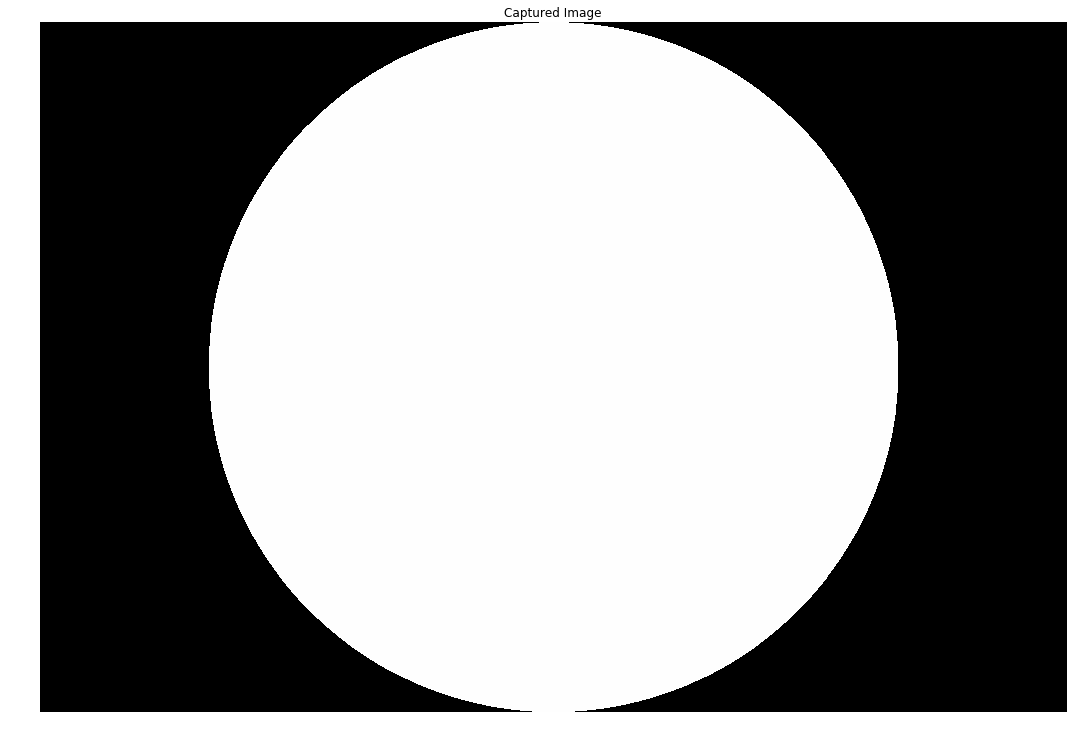

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(img/65535,cmap='gray')
plt.axis('off')
plt.title('Captured Image')
plt.tight_layout()
plt.show()

In [13]:
camera.close()

## Compare high-speed (10bitADC) with low-speed (14bitADC) image with respect to the number of pixel levels.

In [ ]:
print('10bitADC:')
img = cv.imread('../tests/image20190905012252.png', cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH )
print('# of Channels: %d / Datatype: %s' % (img.shape[2], str(img.dtype)))
unique, counts = np.unique(img.flatten(), return_counts=True)
counts = len(dict(zip(unique, counts)))
bits = ceil(log2(counts))
print('# of distinct levels: %d (2^%d=%d)' % ( counts, bits, 2**bits))
print('14bitADC:')
img = cv.imread('../tests/image20190915222325.png', cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH )
print('# of Channels: %d / Datatype: %s' % (img.shape[2], str(img.dtype)))
unique, counts = np.unique(img.flatten(), return_counts=True)
counts = len(dict(zip(unique, counts)))
bits = ceil(log2(counts))
print('# of distinct levels: %d (2^%d=%d)' % ( counts, bits, 2**bits))

# Insert new lines here

In [ ]:
import skimage
from skimage.morphology import watershed, disk
from skimage.filters import threshold_otsu, try_all_threshold, rank
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.exposure import rescale_intensity

from scipy import ndimage as ndi

import matplotlib
import matplotlib.pyplot as plt
import sep

Read in test files for testing the algorithm

In [ ]:
#img = rgb2gray(imread('./tests/image20190403215022.png'))
#img = rgb2gray(imread('./tests/image20190905012252.png'))
#example image with 14bitADC (low speed mode) setting
img = rgb2gray(imread('./images/20190915/image20190915221424.png'))
matplotlib.rcParams['font.size'] = 9
img = np.flip(img, 0)

# measure a spatially varying background on the image

In [ ]:
bkg = sep.Background(img)

In [ ]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

In [ ]:
# show the background
plt.figure(figsize = (15,15))
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [ ]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

In [ ]:
# show the background noise
plt.figure(figsize = (15,15))
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [ ]:
# subtract the background
img_sub = img - bkg
# show the image with background subtracted
plt.figure(figsize = (15,15))
plt.imshow(img_sub, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

First do contrast enhancement by stretching the histogram

In [ ]:
p2, p98 = np.percentile(img, (2, 98))
imgo = rescale_intensity(img, in_range=(p2, p98))

Do segmentation on grayscale image and denoise it

In [ ]:
gray = skimage.img_as_ubyte(skimage.color.rgb2gray(imgo))
denoised = rank.median(gray,disk(2))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(gray,cmap='gray')
ax.set_axis_off()
plt.tight_layout()

Plot histogram of image

In [ ]:
plt.hist(gray.ravel(),bins=256,range=(1,254));

Mark sections for watershed algorithm:
find continuous region (low gradient - where less than 10 for this image) --> markers
disk(10) is used here to get a more smooth image

In [ ]:
markers = rank.gradient(denoised, disk(10)) < 15
markers = ndi.label(markers)[0]
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')

Show elevation map of image

In [ ]:
from skimage.filters import sobel
elevation_map = sobel(gray)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off');

Do watershed segmentation

In [ ]:
labels = watershed(elevation_map, markers)

In [ ]:
plt.subplots(figsize=(15, 15))
plt.imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})
ax0, ax1, ax2, ax3 = ax.ravel()
plt.tight_layout()

ax0.imshow(img, cmap=plt.cm.gray)
ax0.set_title('Original')
ax0.axis('off')

ax2.imshow(try_all, cmap=plt.cm.gray)
ax2.set_title('Original >= Local Otsu' % threshold_global_otsu)
ax2.axis('off')

ax3.imshow(global_otsu, cmap=plt.cm.gray)
ax3.set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax3.axis('off')

plt.tight_layout()
plt.show()